# Classifying handwritten digits from the MNIST dataset

## Fetching MNIST data

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import os
import random
from six.moves import urllib

In [2]:
URL = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
PATH = os.path.join('datasets', 'mnist')
def fetch_data(url=URL, path=PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    file_path = os.path.join(path, url.split('/')[-1])
    urllib.request.urlretrieve(url, file_path)
    return file_path
file_path = fetch_data()

## Loading data

In [3]:
import scipy.io
mnist = scipy.io.loadmat(file_path)

In [4]:
mnist['target'] = mnist.pop('label')    #to match the key name used when downlaoded by sklearn

In [5]:
import numpy as np
X, y = np.transpose(mnist['data']), np.reshape(mnist['target'], np.product(mnist['target'].shape),)

print("Data:", X.shape)
print("Target:", y.shape)

Data: (70000, 784)
Target: (70000,)


### Let's take a peek at one digit from the dataset

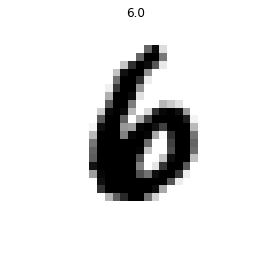

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

rand = random.randint(0, 69999)
some_digit = X[rand]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.title(y[rand])
plt.axis("off")
plt.show()

## Train-test split

### The MNIST dataset is actually already split (60,000 + 10,000)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#Shuffling the training set
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier (simplifying the problem)

In [9]:
#Creating a "5-detector"
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#Running a Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([X[36000]])    #image of a '5'

array([ True])

## Performance Measures

### Accuracy

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9595
0.9695
0.95815


In [12]:
#Using the cross_val_score() function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9595 , 0.9695 , 0.95815])

In [13]:
#95% accuracy? too good to be true. let's try a "dumb" classifier

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

#This shows that accuracy is generally not the preferred performance measure
#for classifiers, especially when dealing with "skewed" datasets.

[0.90965 0.90925 0.91005]


### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

print("Confusion Matrix:\n",confusion_matrix(y_train_5, y_train_pred))

Confusion Matrix:
 [[53759   820]
 [ 1437  3984]]


### Precision and Recall

In [15]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall", recall_score(y_train_5, y_train_pred))

Precision: 0.829308909242298
Recall 0.7349197565024903


### F<sub>1</sub> Score

In [16]:
#The F1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_train_5, y_train_pred))

F1 score: 0.7792665036674816


## Selecting threshold values

In [17]:
y_scores = sgd_clf.decision_function([some_digit])    #to get scores instead of predictions
print(y_scores)
threshold = 0    #changing the threshold value can affect the precision/recall
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-242090.84660759]
[False]


### Precision/Recall Tradeoff

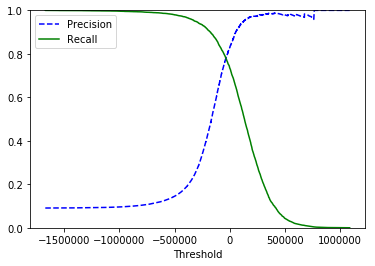

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")    #to get scores instead of predictions

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


In [19]:
#Let's say we aim for a precision of 90%. Looking at the plot, we can see that the corresponding threshold is about 70000
y_train_pred_90 = (y_scores > 70000)
print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.9136239782016349
Recall: 0.6185205681608559


### Receiver Operating Characteristic(ROC) Curve

In [20]:
#The ROC curve plots sensitivity(recall) vs 1-specificity, where specificity is the true negative rate(the 
#ratio of negative instances that are correctly classified as negative)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

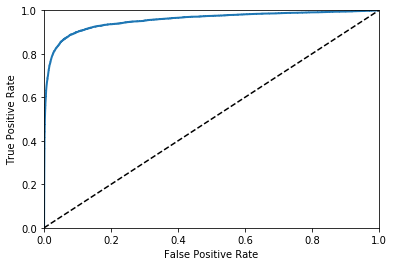

In [21]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2,label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
#A perfect classifier will have a ROC AUC(Area Under Curve) equal to 1.
from sklearn.metrics import roc_auc_score

print("ROC AUC:", roc_auc_score(y_train_5, y_scores))

ROC AUC: 0.9554293540082209


In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

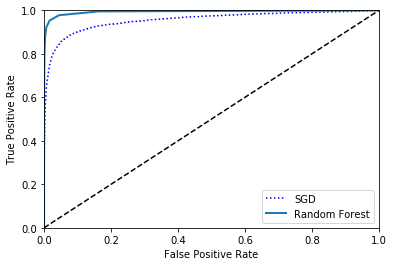

In [24]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [25]:
#The RandomForestClassifier's ROC curve looks much better than the SGDClassifier
print("ROC AUC:", roc_auc_score(y_train_5, y_scores_forest))

ROC AUC: 0.9937546109136732


## Multiclass Classification

In [26]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([6.])

In [27]:
#Under the hood, sklearn actually trained 10 binary classifiers, got their
#decision scores and selected the class with the highest score.
some_digit_scores = sgd_clf.decision_function([some_digit])
print("Scores:", some_digit_scores)

Scores: [[-639127.21609924 -601585.36700562 -283218.37146222 -733624.27728254
  -154220.92598665 -242090.84660759  416039.39016316 -753513.96915621
  -272217.2096374  -524391.2001098 ]]


In [28]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

### Forcing One vs One(OvO) or One vs All(OvA) classification

In [29]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print("Prediction:", ovo_clf.predict([some_digit]))
print("Number of classifiers trained:",len(ovo_clf.estimators_))

Prediction: [6.]
Number of classifiers trained: 45


In [30]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([6.])

In [31]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [32]:
#Evaluating
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87387522, 0.87459373, 0.8700305 ])

In [33]:
#Scaling the imputs incrases accuracy above 90% in this case
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90871826, 0.91034552, 0.90873631])

## Error Analysis

In [34]:
#confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:", conf_mx)

Confusion Matrix: [[5726    2   29    9   11   47   47    8   37    7]
 [   1 6492   45   30    6   34    7   11  104   12]
 [  51   39 5322  110   82   25   96   58  160   15]
 [  46   38  151 5350    3  220   32   53  142   96]
 [  23   25   33   12 5377    9   55   28   81  199]
 [  75   38   38  193   78 4583  116   26  171  103]
 [  35   23   48    3   40   99 5623    4   43    0]
 [  27   25   69   28   58    7    9 5760   15  267]
 [  50  162   74  150   13  158   55   25 5021  143]
 [  42   37   29   87  168   32    3  172   77 5302]]


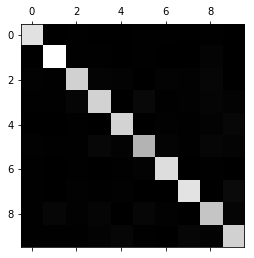

In [35]:
#That's a lot of numbers. It's often more convenient to loook at an image
#representation of the confusion matrix (so as not to get confused, duh)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

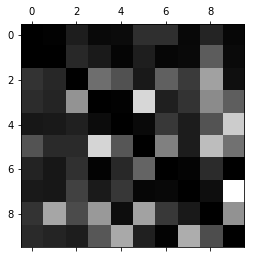

In [36]:
#Comparing error rates instead of absolute number of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

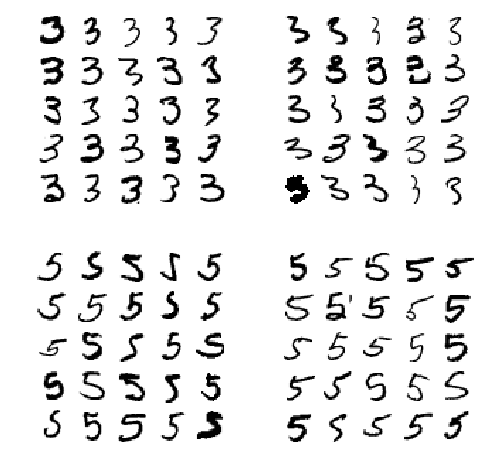

In [37]:
#Let's plot examples of 3s and 5s to analyze errors.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):    #code from https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [38]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False, False]])

In [39]:
#Evaluating  (commenting this out because it takes a long time to run)
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
#f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classification

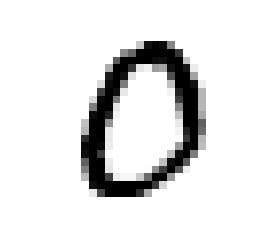

In [44]:
#Let's build a system that removes noise from images

#Creating noise in the inputs
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

#Training the denoiser
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 5500
clean_digit = knn_clf.predict([X_test_mod[some_index]])

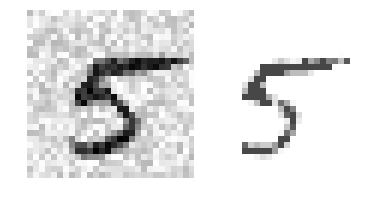

In [48]:
plot_digits([X_test_mod[some_index], clean_digit])